##### Packages

In [1]:
import numpy as np
import pandas as pd
from scipy import linalg, matrix
from sympy import Matrix
import scipy
import cv2
import matplotlib.pyplot as plt
from scipy.optimize import least_squares
import time
import hw201Func as fc
import visualize 

In [2]:
pts_2d_1 = np.load('./data/Point2D_1.npy' )
pts_2d_2 = np.load('./data/Point2D_2.npy' )
path_3d = './data/Point3D.txt'
pts_3d = []
f = open(path_3d,'r') 
for line in f.readlines():
    tmp =line.split('\n')[0].split(' ')
    tmp = list(map(lambda x :int(x),tmp))
    pts_3d.append(tmp)
f.close()

pts_2d_1=np.asarray(pts_2d_1)   # 2d points from clicker.py
pts_2d_2=np.asarray(pts_2d_2)
pts_3d = np.asarray(pts_3d) # 3d points


## Part. A 

In [3]:
#%% =============================================================================
#    1-A. projection matrix by using least-squared method
# =============================================================================
## (0) normalization
T2d_1, normpts_2d_1 = fc.normalization(2,pts_2d_1)
T2d_2, normpts_2d_2 = fc.normalization(2,pts_2d_2)
T3d, normpts_3d = fc.normalization(3,pts_3d)
#print('T2d_1:\n',T2d_1)
#print('normpts_2d_1:\n',normpts_2d_1)
## (1) find estimated P as first mtrix for latter optimzation 
''' method0:eigen vector with smallest eigen value'''
#P1 = computePmatrix1(normpts_2d_1,normpts_3d,T2d_1,T3d,method = 0)
#P2 = computePmatrix1(normpts_2d_2,normpts_3d,T2d_2,T3d,method = 0)
''' method1:SVD '''
P1 = fc.computePmatrix1(normpts_2d_1,normpts_3d,T2d_1,T3d,method = 1)
P2 = fc.computePmatrix1(normpts_2d_2,normpts_3d,T2d_2,T3d,method = 1)
print('P1:\n',P1)
print('P2:\n',P2)
        # =============================================#
        #                   TEST                       #
        # =============================================#
        
test_2d_1, real_2d_1=fc.project(P1,pts_3d,pts_2d_1)
test_2d_2, real_2d_2=fc.project(-P2,pts_3d,pts_2d_2)

rmse_P = fc.rmse(test_2d_1, real_2d_1)
print('rmse of P1:',rmse_P)
rmse_P2 = fc.rmse(test_2d_2, real_2d_2)
print('rmse of P2:',rmse_P2)

## (2)
for i,estP in enumerate((P1,P2)):
    M = linalg.det(estP[:3,:3])
    print('%d :det(M)= %f'%(i+1,M) )
    if np.sign(M) < 0: 
        print('det(M) < 0 , Negating...')  
        if i == 0: P1 = estP*np.sign(M)
        else: P2 = estP*np.sign(M) 
    else:
        print('det(M) > 0')   

P1:
 [[-2.44331738e+01  4.97037531e+00  7.66044536e+00 -5.59566939e+01]
 [ 1.11083587e+00 -3.62266508e+00  3.03357954e+01 -1.87345426e+02]
 [-4.21469043e-03  4.08689524e-02  3.76854265e-02 -6.21818238e-01]]
P2:
 [[-2.03414561e+01 -7.26923835e+00  5.58575429e+00 -9.25824766e+01]
 [ 2.08534600e+00 -2.44984866e+00  2.42884676e+01 -1.54105204e+02]
 [-1.98384482e-02  2.68821092e-02  2.51098772e-02 -5.14608440e-01]]
rmse of P1: 0.7566816148253368
rmse of P2: 0.8286659577525883
1 :det(M)= 33.014963
det(M) > 0
2 :det(M)= 18.457705
det(M) > 0


## Part. B + C

================== fro P1 ===================
detR: 1.0
intrinsic K:
 [[426.93070807  -1.66030467 191.36298232]
 [  0.         446.25643105 318.66439243]
 [  0.           0.           1.        ]]
Rotation R:
 [[-0.99224831 -0.12235778  0.02172232]
 [ 0.0986319  -0.66907203  0.73662363]
 [-0.07559784  0.73305607  0.67595397]]
translation t:
 [[  2.65004895]
 [  0.43433054]
 [-11.15339655]]
rmse:0.756682


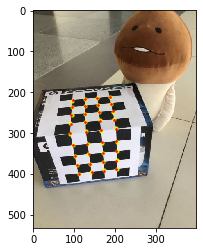

================== fro P2 ===================
detR: 0.9999999999999998
intrinsic K:
 [[495.04892263  12.10980084 199.45298354]
 [  0.         510.73483003 287.77019527]
 [  0.           0.           1.        ]]
Rotation R:
 [[-0.80084402 -0.59881464  0.00835918]
 [ 0.36514726 -0.47718285  0.79935224]
 [-0.47467497  0.64320879  0.60080456]]
translation t:
 [[  0.49301034]
 [ -0.28184983]
 [-12.31304701]]
rmse:0.828666


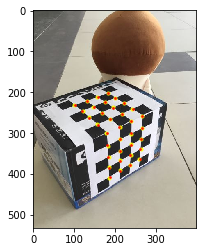

In [6]:
#%% =============================================================================
#    B. decompose P into K[R|t] by using Gram-Schmidt process
# =============================================================================
P_all =[P1,P2]
PTS_2d = [pts_2d_1,pts_2d_2]
IMG_path = ['./data/chessboard_1.jpg','./data/chessboard_2.jpg']
R_=[]
T_=[]
for i,(estP,pts_2d,imgpath) in enumerate(zip(P_all, PTS_2d, IMG_path)):
    print('================== fro P%d ==================='%(i+1))
    K,R,T = fc.KRT(estP)
    detR = linalg.det(R)
    print('detR:',detR)
    if detR - 1 > 1e-7 :
        print('det(R) != 1')
    print('intrinsic K:\n',K)
    print('Rotation R:\n',R)
    print('translation t:\n',T)
    R_.append(R)
    T_.append(T)
    #%% =============================================================================
#   C. Re-project 2D points on each chessboard images by using K,R,t.
#      (2 images+ compute the point re-projection root-mean-squared errors) 
# =============================================================================
    RT = np.vstack((np.hstack((R, np.matrix(T))),[0,0,0,1]))
    I = [[1,0,0,0],[0,1,0,0],[0,0,1,0]]
    proj_Mat = np.dot(np.dot(K,I),RT)
    
    KR = np.dot(K,R)
    Kt = np.dot(K,T)
    KRt = np.hstack((KR,Kt))
    
    proj_2ds, real_2ds = fc.project(mat = KRt, loc_3d = pts_3d, loc_2d=pts_2d)
    
    rmse_2d = fc.rmse(real_2ds, proj_2ds)
#    print('\nreal 2d:\n',np.asarray(real_2ds).squeeze())
#    print('projected 2d:\n',np.asarray(proj_2ds).squeeze())
    print('rmse:%f'%rmse_2d)
    
    fc.plot2img(click_pts =real_2ds , proj_pts=proj_2ds, path=imgpath,num=i)

## Part. D

Angle between two cameras:  24.00517203571544


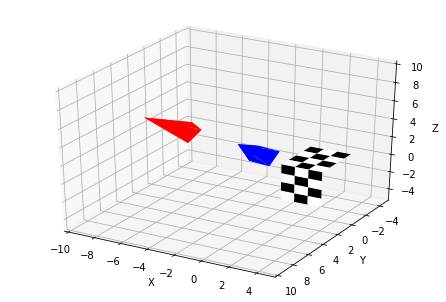

In [7]:
#%% ===========================================================================
#  D. (1).Plot camera poses for R,t  
#     (2).compute the angle between the two camera pose vectors.
# =============================================================================
visualize.visualize(pts=pts_3d, R1=R_[0], T1=T_[0], R2=R_[1], T2=T_[1])
